# Курсовой проект Игнат Александра

## Задание для курсового проекта

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

### Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

In [3]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [6]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [42]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [43]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [44]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Пути к директориям и файлам

In [7]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'
PREDICTONS_PATH = './Ignat_predictions.csv'

### Загрузка данных

In [8]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

## 1. Обзор обучающего датасета

**Данные обучающего датасета**

In [9]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [10]:
train_df.shape

(7500, 17)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [12]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Данные тренировочного датасета**

In [13]:
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [14]:
test_df.shape

(2500, 16)

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

**Проверим соответствие размеров**

In [16]:
train_df.shape[1]-1 == test_df.shape[1]

True

**Объединенные данные**

In [17]:
data = pd.concat([train_df, test_df], axis=0)
data = data.reset_index(drop=True)
data.shape

(10000, 17)

In [18]:
data.tail(n=3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
9997,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0,NaN
9998,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0,NaN
9999,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0,NaN


**Обзор количественных признаков**

In [19]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.930000e+03,10000.000000,10000.00000,10000.000000,1.000000e+04,10000.00000,4561.000000,9983.000000,1.000000e+04,1.000000e+04,10000.000000,7930.000000,7500.000000
mean,1.366525e+06,0.031400,11.14430,18.319580,8.865079e+05,0.16800,34.564569,0.114595,1.194381e+07,2.914741e+05,18303.675600,1171.992182,0.281733
std,8.638276e+05,0.304341,4.89476,7.095357,1.389982e+07,0.51459,21.771990,0.349729,3.200878e+07,3.339979e+05,11831.647516,1639.812951,0.449874
min,1.065330e+05,0.000000,1.00000,3.900000,0.000000e+00,0.00000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.459892e+05,0.000000,8.00000,13.500000,2.788115e+05,0.00000,16.000000,0.000000,1.805485e+05,1.132258e+05,10059.750000,711.000000,0.000000
50%,1.168814e+06,0.000000,10.00000,17.000000,4.781810e+05,0.00000,32.000000,0.000000,3.117180e+05,2.090190e+05,16200.000000,731.000000,0.000000
75%,1.638693e+06,0.000000,14.00000,22.000000,7.943595e+05,0.00000,50.000000,0.000000,5.210700e+05,3.619500e+05,23888.250000,743.000000,1.000000
max,1.497561e+07,15.000000,48.00000,57.700000,1.304726e+09,15.00000,118.000000,5.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


**Обзор номинативных признаков**

In [20]:
for cat_colname in data.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(data[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    4862
Rent             4224
Own Home          895
Have Mortgage      19
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    3142
2 years       917
3 years       848
< 1 year      770
5 years       685
1 year        657
4 years       621
6 years       563
7 years       536
8 years       446
9 years       358
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      7917
other                    905
home improvements        552
business loan            159
buy a car                130
medical bills             98
buy house                 53
take a trip               51
major purchase            49
small business            31
wedding                   17
educational expenses      13
moving                    12
vacation  

### Приведение типов

In [21]:
data.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                  float64
dtype: object

**Dummies**

In [22]:
for cat_colname in data.select_dtypes(include='object').columns[1:]:
    data = pd.concat([data, pd.get_dummies(data[cat_colname], prefix=cat_colname)], axis=1)

In [23]:
data.dtypes

Home Ownership                     object
Annual Income                     float64
Years in current job               object
Tax Liens                         float64
Number of Open Accounts           float64
Years of Credit History           float64
Maximum Open Credit               float64
Number of Credit Problems         float64
Months since last delinquent      float64
Bankruptcies                      float64
Purpose                            object
Term                               object
Current Loan Amount               float64
Current Credit Balance            float64
Monthly Debt                      float64
Credit Score                      float64
Credit Default                    float64
Years in current job_1 year         uint8
Years in current job_10+ years      uint8
Years in current job_2 years        uint8
Years in current job_3 years        uint8
Years in current job_4 years        uint8
Years in current job_5 years        uint8
Years in current job_6 years      

## 2. Обработка выбросов

In [24]:
data.loc[data['Years in current job'].isnull(), 'Years in current job'] = '< 1 year'

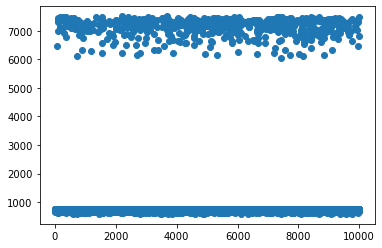

In [25]:
plt.scatter(data.index, data["Credit Score"])
plt.show()

In [26]:
data.loc[data['Credit Score'] > 1000, 'Credit Score'] = data['Credit Score'] / 10

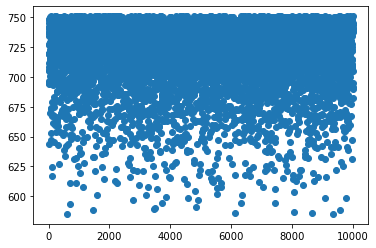

In [27]:
plt.scatter(data.index, data["Credit Score"])
plt.show()

## 3. Обработка пропусков

In [28]:
len(data) - data.count()

Home Ownership                       0
Annual Income                     2070
Years in current job                 0
Tax Liens                            0
Number of Open Accounts              0
Years of Credit History              0
Maximum Open Credit                  0
Number of Credit Problems            0
Months since last delinquent      5439
Bankruptcies                        17
Purpose                              0
Term                                 0
Current Loan Amount                  0
Current Credit Balance               0
Monthly Debt                         0
Credit Score                      2070
Credit Default                    2500
Years in current job_1 year          0
Years in current job_10+ years       0
Years in current job_2 years         0
Years in current job_3 years         0
Years in current job_4 years         0
Years in current job_5 years         0
Years in current job_6 years         0
Years in current job_7 years         0
Years in current job_8 ye

In [29]:
data.loc[data['Annual Income'].isnull(), 'Annual Income'] = data['Annual Income'].median()
data.loc[data['Months since last delinquent'].isnull(), 'Months since last delinquent'] = data['Months since last delinquent'].median()
data.loc[data['Bankruptcies'].isnull(), 'Bankruptcies'] = data['Bankruptcies'].median()
data.loc[data['Credit Score'].isnull(), 'Credit Score'] = data['Credit Score'].median()

In [30]:
len(data) - data.count()

Home Ownership                       0
Annual Income                        0
Years in current job                 0
Tax Liens                            0
Number of Open Accounts              0
Years of Credit History              0
Maximum Open Credit                  0
Number of Credit Problems            0
Months since last delinquent         0
Bankruptcies                         0
Purpose                              0
Term                                 0
Current Loan Amount                  0
Current Credit Balance               0
Monthly Debt                         0
Credit Score                         0
Credit Default                    2500
Years in current job_1 year          0
Years in current job_10+ years       0
Years in current job_2 years         0
Years in current job_3 years         0
Years in current job_4 years         0
Years in current job_5 years         0
Years in current job_6 years         0
Years in current job_7 years         0
Years in current job_8 ye

## 4. Анализ данных

In [31]:
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,Own Home,482087.0,< 1 year,0.0,11.0,26.3,685960.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,32.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
TARGET_NAME = "Credit Default"
BASE_FEATURE_NAMES = train_df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = data.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

### Разбиение на train и test

In [33]:
train = data[data[TARGET_NAME].notnull()]
test = data[data[TARGET_NAME].isnull()]

**Обзор распределения**

In [34]:
train[TARGET_NAME].value_counts()

0.0    5387
1.0    2113
Name: Credit Default, dtype: int64

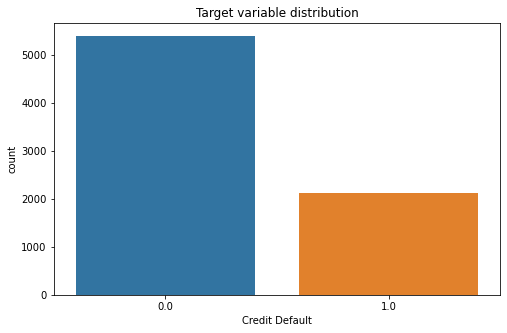

In [35]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

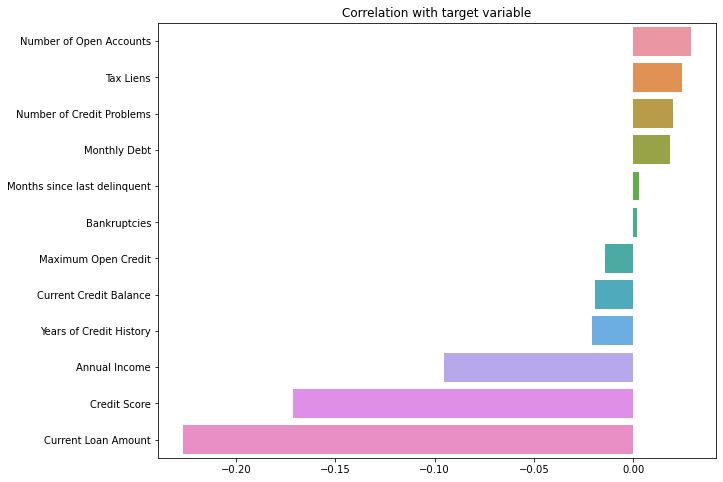

In [36]:
corr_with_target = train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Оценка признака "Credit Score" в разрезе целевой переменной**

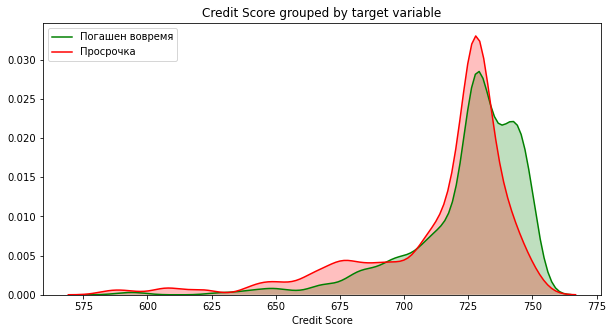

In [37]:
Credit_Score_with_target_s = train[['Credit Score', TARGET_NAME]].sample(1000)
Credit_Score_s = Credit_Score_with_target_s['Credit Score']
Credit_Score_target_0 = Credit_Score_s[Credit_Score_with_target_s[TARGET_NAME] == 0]
Credit_Score_target_1 = Credit_Score_s[Credit_Score_with_target_s[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Credit_Score_target_0, shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(Credit_Score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

In [38]:
shapiro(Credit_Score_s)

ShapiroResult(statistic=0.8038457632064819, pvalue=4.065480640439483e-33)

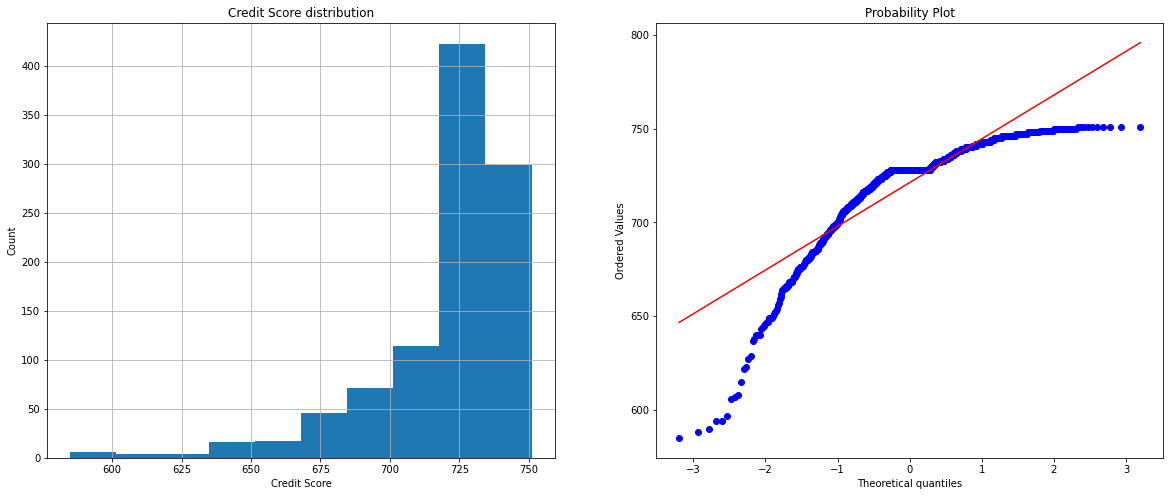

In [39]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
Credit_Score_s.hist()

plt.subplot(122)
probplot(Credit_Score_s, dist='norm', plot=plt)

plt.show()

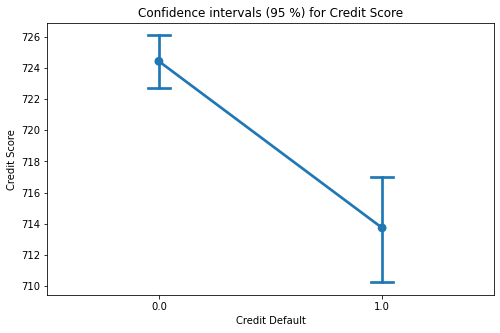

In [40]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=Credit_Score_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

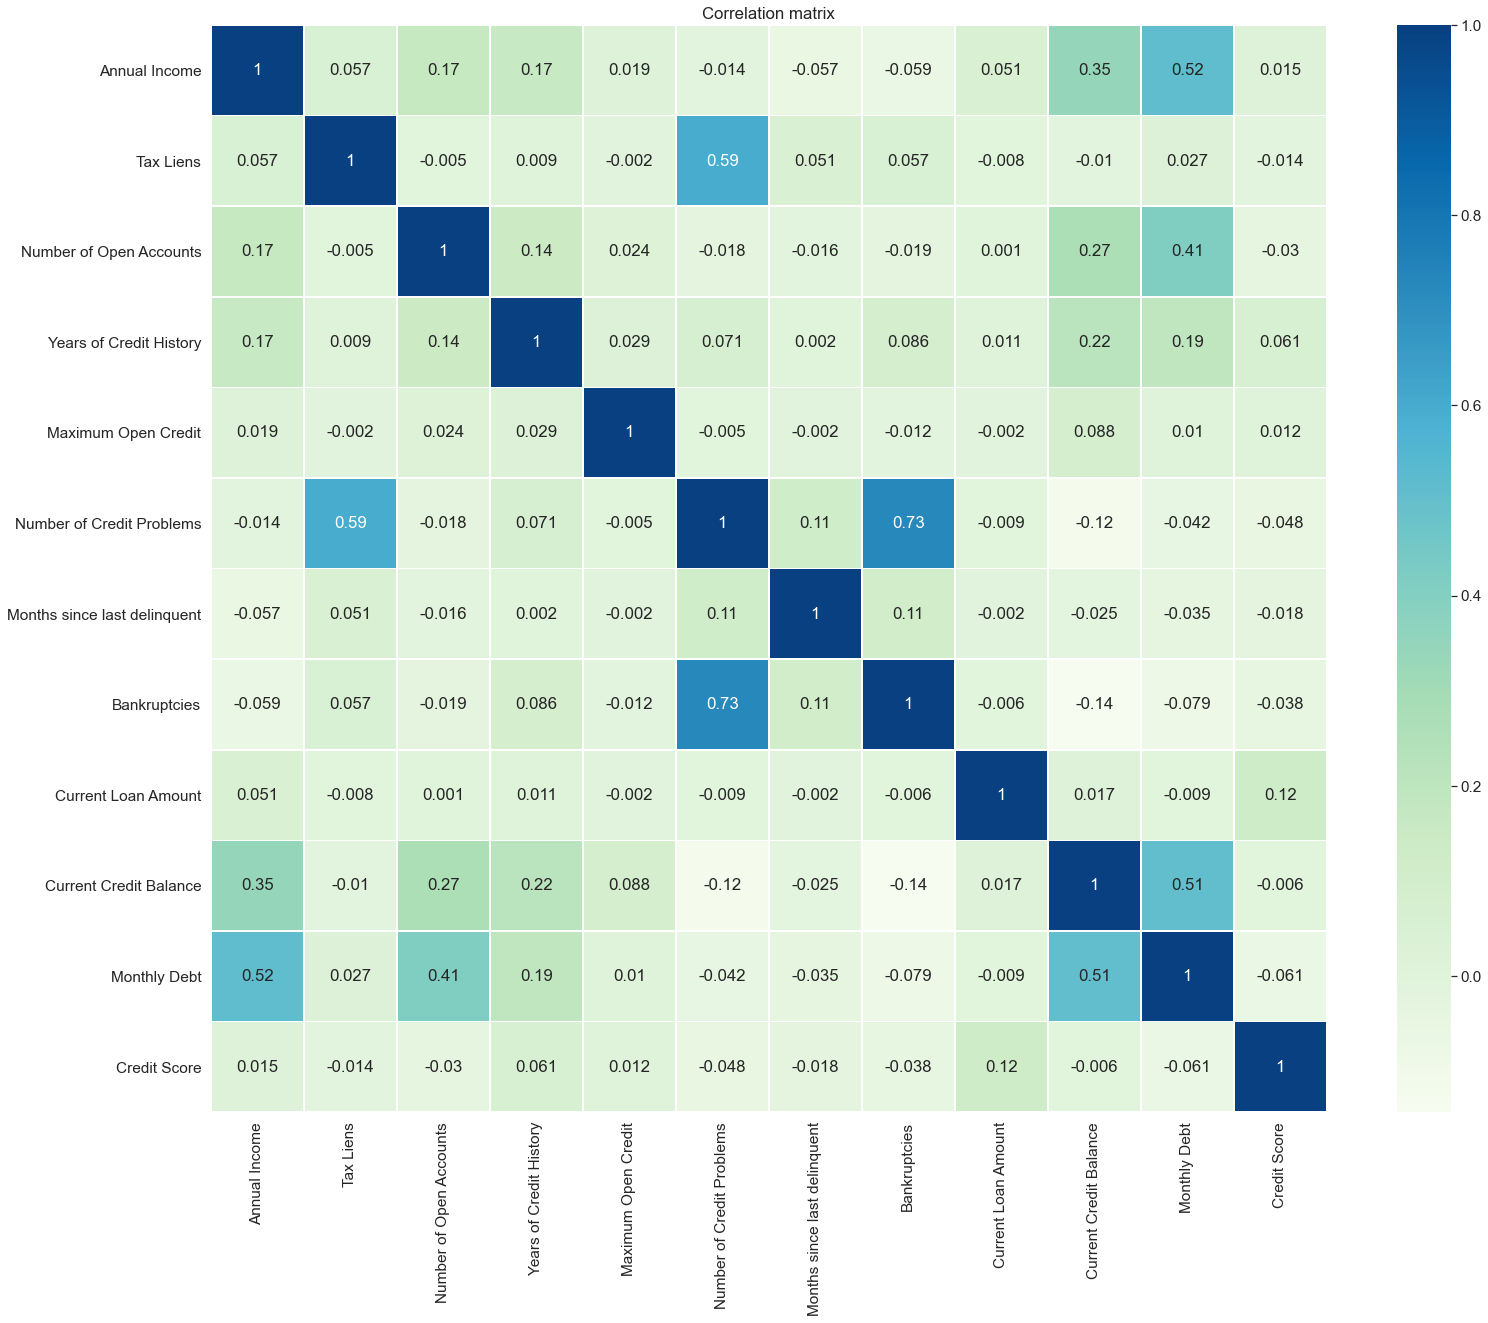

In [41]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## 5. Отбор признаков

## 6. Балансировка классов

## 7. Подбор моделей, получение бейзлана

## 8. Выбор наилучшей модели, настройка гиперпараметров

## 9. Проверка качества, борьба с переобучением

## 10. Интерпретация результатов